# Lab #8 (SARIMA Models)
### By Stakhov K.V. [8.1212]

### Write a program to approximate the flights series from the exercise 6 using the ARIMA method using the `pmdarima` package.
### The series has seasonality, so the program must find the best combination of the `AutoARIMA` class (see http://alkaline-ml.com/pmdarima/auto_examples/arima/example_auto_arima.html ). The program must plot the initial series and ARIMA model.

### 1. For data from `monthly-stats.csv`, models should be built for the dependency `distance(year,month)` using values for years 2017 - 2018 as training data and for the year 2019 as validation data.

### First of all, we'll define a function to join the `month` and `year` column values into an array of `"month-year"` strings:

In [2]:
import pandas as pd

def join_date(df):
    return pd.to_datetime(
        df['month'].map(str)+ '-' +df['year'].map(str),
        format='%m-%Y'
    ).dt.strftime('%m-%Y')

### Then we'll load the monthly dataset and prepare only those columns that are required for our model:

In [3]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

dst_col, year_col, mon_col = "distance", "year", "month"
# Load the monthly statistics dataset and select only the 3 needed columns from it
data = pd.read_csv(
    "../input/domestic-jet-flights-usa/monthly-stats.csv"
)[[dst_col, year_col, mon_col]]

# Prepare the data
x_df = data[[year_col, mon_col]]
feature_names = x_df.columns
y_name = dst_col
y = data[dst_col].values
x = x_df.values

data_train = data[(data["year"] == 2017) | (data["year"] == 2018)]
data_test = data[data["year"] == 2019]
y_train, x_train = data_train[dst_col].values, data_train[[year_col, mon_col]].values
y_test, x_test = data_test[dst_col].values, data_test[[year_col, mon_col]].values

x_points = join_date(data).values
x_train_points = join_date(data_train).values
x_test_points = join_date(data_test).values

print(f"Training data:\n{data_train}\n")
print(f"Testing data:\n{data_test}\n")
print(f"Training y:\n{y_train}\n\nTraining x:\n{x_train_points}\n")
print(f"Testing y:\n{y_test}\n\nTesting x:\n{x_test_points}\n")

Training data:
        distance  year  month
0   26577.789824  2017      1
1   23789.938702  2017      2
2   26486.162291  2017      3
3   25700.390905  2017      4
4   26380.880091  2017      5
5   26109.712089  2017      6
6   27309.899691  2017      7
7   26998.432703  2017      8
8   25404.675682  2017      9
9   26199.605137  2017     10
10  25494.423758  2017     11
11  27100.538073  2017     12
12  24742.567753  2018      1
13  22312.662718  2018      2
14  24949.037986  2018      3
15  23994.569477  2018      4
16  24853.837448  2018      5
17  24460.743199  2018      6
18  25490.019473  2018      7
19  25082.227224  2018      8
20  23899.683598  2018      9
21  24460.281342  2018     10
22  23835.518825  2018     11
23  25169.993984  2018     12

Testing data:
        distance  year  month
24  24914.017190  2019      1
25  22485.864824  2019      2
26  25078.764220  2019      3
27  24106.869974  2019      4
28  24843.179108  2019      5
29  24335.077109  2019      6
30  25311.

### Now we'll implement a function that will fit a SARIMA model via the specified method using our training series, make predictions and test them against our testing series:

In [4]:
import pmdarima as pm
from pmdarima import model_selection

def test_model(method):
    # Fit an ARIMA model using our time series
    mod = pm.auto_arima(
        y_train,
        seasonal = True, m = 12, # Our series contains monthly data
        start_p = 0, start_q = 0, start_P = 0, start_Q = 0,
        max_p = 1000, max_q = 1000, max_P = 1000, max_Q = 1000,
        method = method,
        stepwise = True,
        maxiter = 100,
        trace = True,
        suppress_warnings = True, error_action='ignore'
    )

    print(mod.summary())

    # Use the model to generate predictions
    pred, conf_int = mod.predict(n_periods = y_test.shape[0], return_conf_int = True)

    # Evaluate the correctness of the resulting predictions
    print("\nActual vs Predicted data:\nMonth     Actual       Predicted")
    for i in range(len(pred)):
        print(f"{x_test_points[i]} | {y_test[i]:.3f}    {pred[i]:.3f}")
    print(f"Test Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, pred)):.3f}")

    # Plot raw data and predictions obtained from the model
    fig, ax = plt.subplots(figsize = (15, 7))
    plt.xticks(rotation = 90)
    ax.set(
        xlabel = "Month-Year",
        ylabel = "Distance",
        title = "Distance(Year, Month) for USA Monthly Domestic Jet Flights"
    )

    ax.plot(x_train_points, y_train, label = "Training data")
    ax.plot(x_test_points,
            pred,
            label = "Predicted data")
    ax.scatter(x_test_points, y_test, marker = 'x', label = "Testing data")
    ax.grid()
    ax.legend()
    ax.fill_between(
        x_test_points,
        conf_int[:, 0], conf_int[:, 1],
        alpha = 0.1, color = 'b'
    )

### After this we can compare the accuracy of models built using different methods.

### a) Let's first test the `limited-memory Broyden-Fletcher-Goldfarb-Shanno` method (default when using `auto_arima` with `method` keyword unspecified):

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=404.528, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=397.628, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=400.030, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=402.569, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=397.930, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=397.564, Time=0.53 sec
 ARIMA(1,1,0)(3,0,0)[12] intercept   : AIC=399.502, Time=1.28 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=400.452, Time=0.82 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(1,1,0)(3,0,1)[12] intercept   : AIC=inf, Time=4.88 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=407.993, Time=0.17 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=397.808, Time=0.24 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=397.141, Time=0.89 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=397.714, Time=0.22 sec
 ARIMA(1,1,1)(3,0,0)[12] intercept   : AI

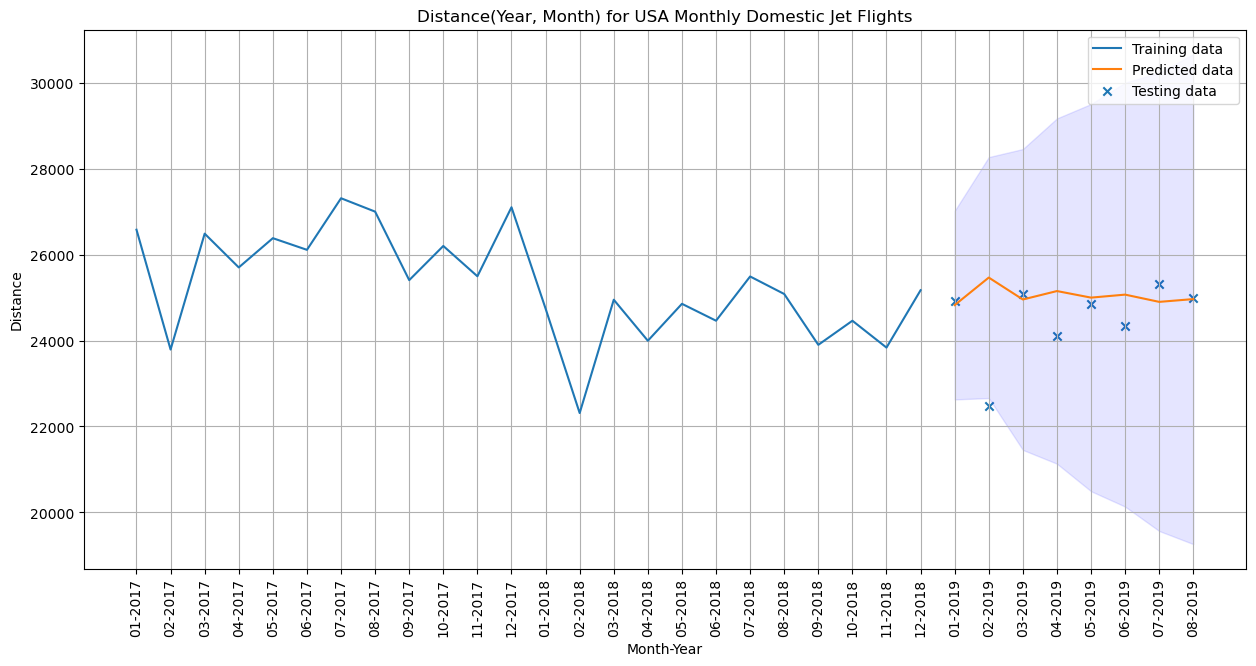

In [5]:
test_model("lbfgs")

### b) Then we'll use the `Nelder-Mead` method:

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=404.528, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=397.561, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=402.036, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=402.569, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=397.912, Time=0.10 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=400.872, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=399.619, Time=0.26 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=397.486, Time=0.22 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=399.415, Time=0.32 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=401.866, Time=0.35 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=405.973, Time=0.21 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=399.995, Time=0.22 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=404.364, Time=0.22 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=402.176, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12]         

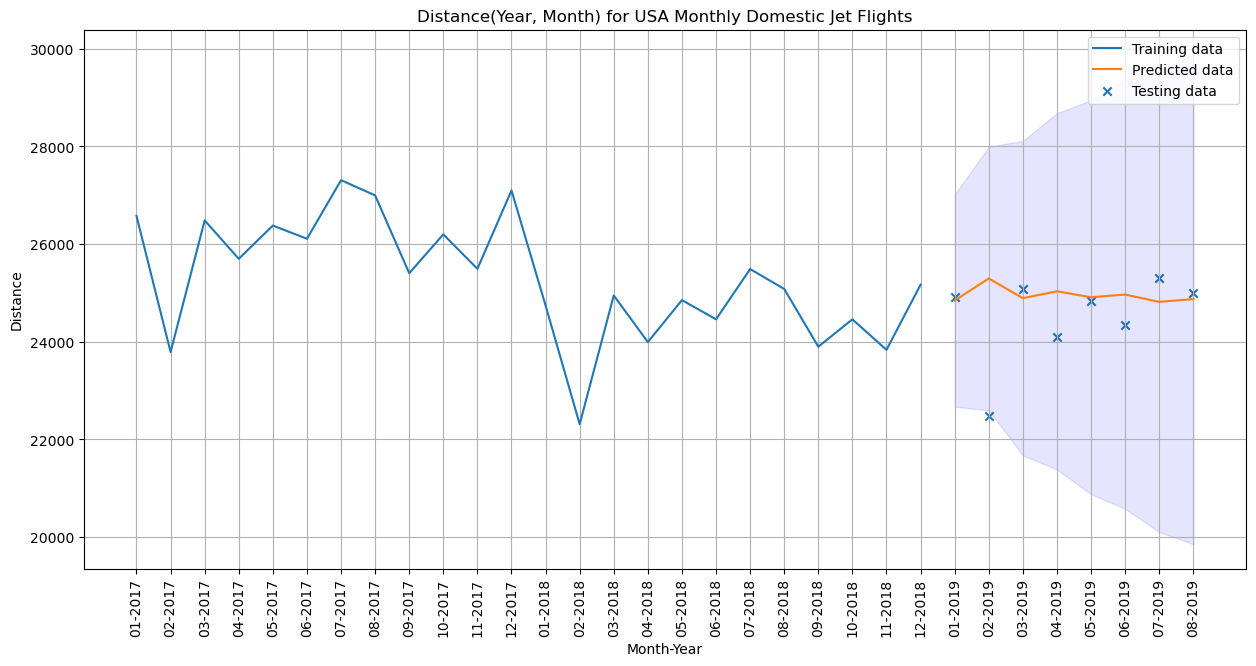

In [6]:
test_model("nm")

### c) Powell's method:

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=404.528, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=397.151, Time=0.29 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=399.944, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=402.569, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=397.856, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=397.510, Time=0.54 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=399.144, Time=0.26 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=397.003, Time=0.17 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=397.586, Time=0.56 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=399.506, Time=0.73 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=405.973, Time=0.11 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=396.598, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=397.820, Time=0.12 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=398.769, Time=0.41 sec
 ARIMA(2,1,0)(0,0,2)[12] intercep

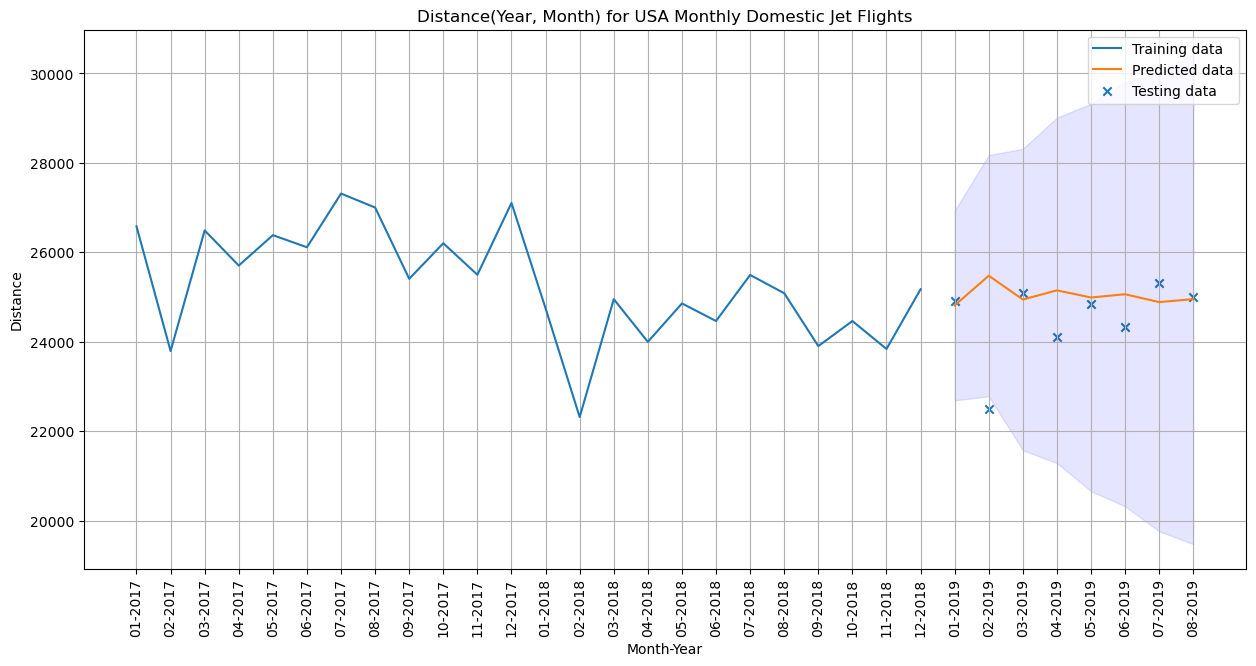

In [7]:
test_model("powell")

### d) Conjugate gradient:

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=686.426, Time=0.18 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=2.97 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=634.535, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=482.603, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=517.125, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=494.560, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=480.597, Time=0.02 sec
 AR

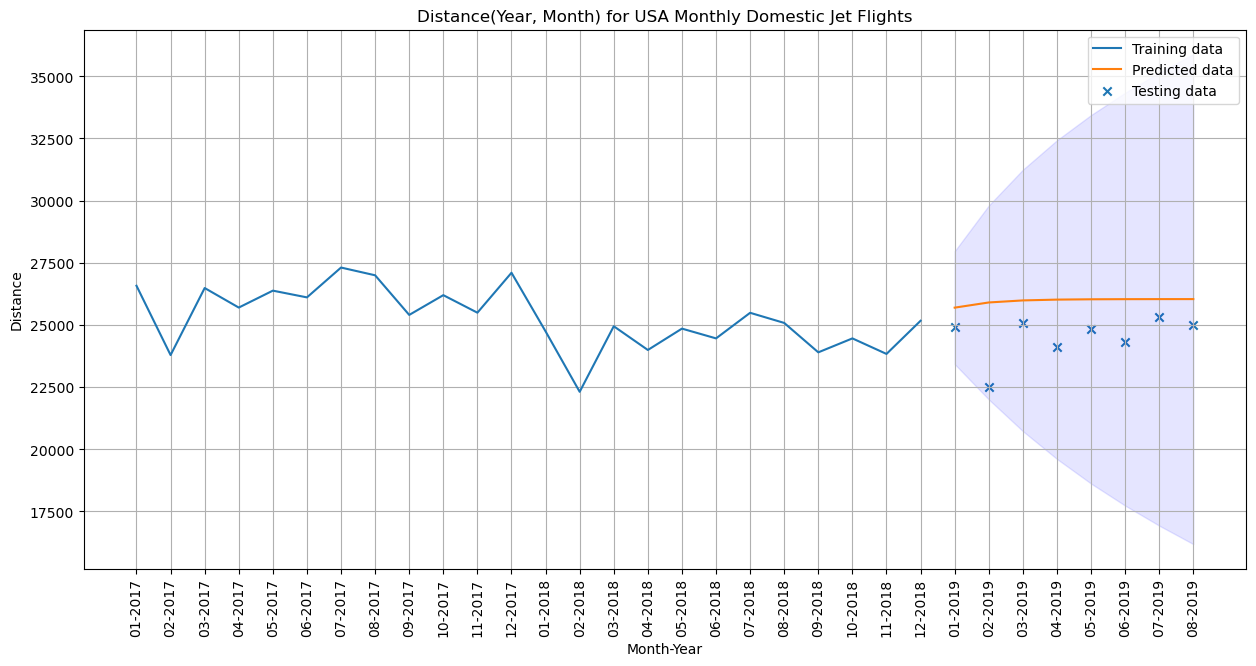

In [8]:
test_model("cg")

### As a result, we can choose the `Nelder-Mead` SARIMA model as the most accurate one.